In [191]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [192]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [193]:
len(words)

32033

In [194]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [195]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [196]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Added operation to bring values closer to 0 at initialization.
# Preactivations being too high can cause squashing function to
# squash the values to -1 or 1, essentially making the nodes passthrough
# and killing their ability to learn.
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # on initialize, multiply by (gain / sqrt(fan_in)) https://pytorch.org/docs/stable/nn.init.html # kaiming_normal
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [197]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    
    #break

      0/  20000: 3.3239
  10000/  20000: 2.0322


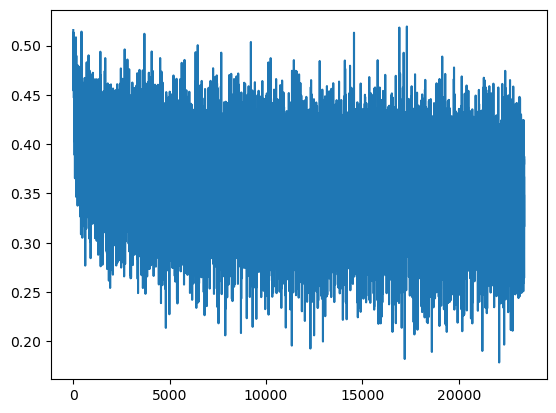

In [148]:
plt.plot(lossi)

In [198]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [199]:
bnmean

tensor([[-1.3176,  0.0348, -1.2865,  0.8570,  0.7076,  0.3253,  1.2219, -1.2853,
          0.3160,  1.2237, -1.2991, -1.6333, -0.1006, -0.3978, -0.1814,  0.1604,
          0.5137, -1.7008, -0.4305,  1.1226,  0.3120, -0.2897, -0.1868,  0.5342,
          0.8704,  0.6203,  0.7781, -0.2956,  0.0528,  1.0914, -0.5097, -0.7522,
          0.0966,  0.1706, -0.3956, -0.8787, -1.2751, -0.1868, -0.2750,  0.4095,
         -0.0674, -0.8334, -0.5677,  0.2580,  0.5004,  0.1767,  0.5512, -0.3670,
          1.2481,  1.2033,  0.7014, -0.0170,  1.1448,  1.0848,  0.7293, -1.1917,
         -0.3728,  0.4242,  1.0683, -1.0660, -0.6111,  0.3912,  0.4616,  0.0190,
          1.1299,  0.7966, -0.1496,  0.8402, -0.3938, -0.1361, -0.1057,  0.7076,
          0.5057, -1.1106, -1.6261,  0.0854,  0.6995, -0.0407,  0.1548,  0.4317,
          0.5636,  1.1653,  0.9220,  0.4075,  0.2958, -0.3756, -1.0791,  0.3705,
          0.5696, -0.4977, -0.3752,  0.8570, -0.2572, -0.3480, -0.4535,  0.0490,
         -0.5096, -0.1692,  

In [200]:
bnmean_running

tensor([[-1.3280e+00, -1.1351e-02, -1.3079e+00,  8.2579e-01,  7.2675e-01,
          3.2582e-01,  1.2083e+00, -1.2558e+00,  3.3246e-01,  1.2357e+00,
         -1.2817e+00, -1.5566e+00, -5.2675e-02, -3.9843e-01, -1.8077e-01,
          2.5996e-01,  5.3732e-01, -1.6695e+00, -4.7893e-01,  1.1135e+00,
          3.5028e-01, -3.0806e-01, -1.3642e-01,  5.3826e-01,  8.4641e-01,
          6.4689e-01,  7.8582e-01, -2.4564e-01,  7.5297e-02,  1.0735e+00,
         -4.9703e-01, -7.2790e-01,  6.5130e-02,  1.8457e-01, -4.0146e-01,
         -8.7381e-01, -1.2255e+00, -2.0167e-01, -2.6206e-01,  3.9802e-01,
         -5.6076e-04, -8.4277e-01, -5.2560e-01,  2.5340e-01,  4.8157e-01,
          1.3635e-01,  5.7925e-01, -3.5951e-01,  1.1968e+00,  1.2113e+00,
          7.2311e-01, -2.9660e-02,  1.1739e+00,  1.0750e+00,  7.2505e-01,
         -1.1178e+00, -3.5405e-01,  4.0018e-01,  1.0496e+00, -1.0735e+00,
         -6.0237e-01,  3.5881e-01,  5.3830e-01,  4.4301e-03,  1.1385e+00,
          8.1250e-01, -1.4164e-01,  8.

In [118]:
@torch.no_grad() # this decorator disables gradient tracking -- improves efficiency when .backward is not going to be called
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # hidden layer pre-activation
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(embcat @ W1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.3605451583862305
val 2.4363131523132324


In [64]:
# sample from model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
ambrie.
khy.
mili.
tatyanna.
sane.
rahnie.
delynn.
jareei.
ner.
kiah.
maiha.
kaleigh.
ham.
jois.
quint.
sulie.
alianni.
wanell.
dearynn.


In [201]:
# PyTorchify code

In [203]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [204]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # Just for debugging

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

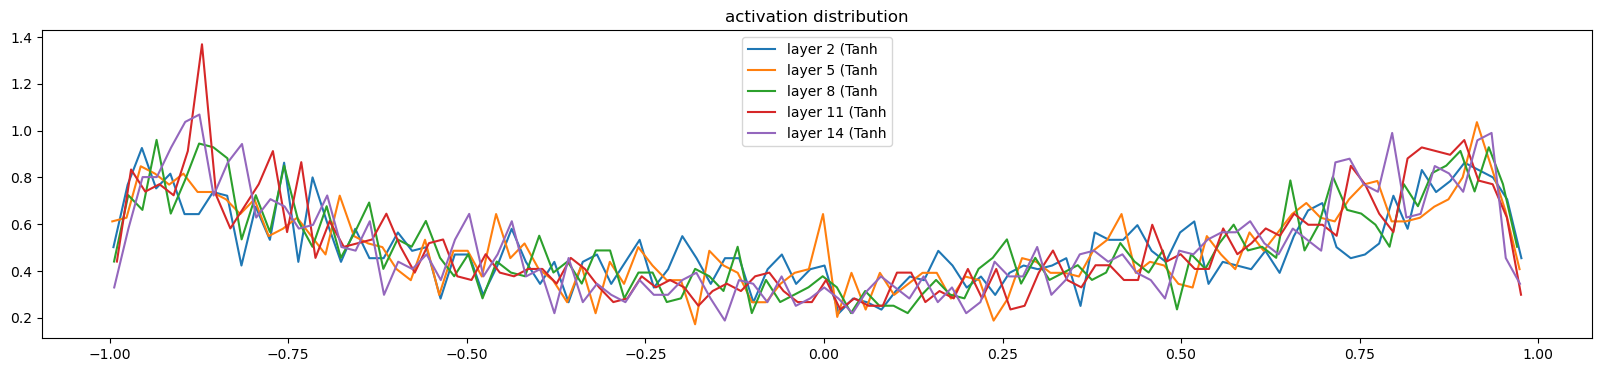

In [206]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')